###**Import Library**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

###**Import Dataset**

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample = pd.read_csv("/content/sample_submission.csv")

###**Digging Information**

making summary table

In [ ]:
def summary(df):
    print(f'data shape: {df.shape}')

    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values

    desc = pd.DataFrame(df.describe(include='all').transpose())

    return summ

In [ ]:
summary(train)

data shape: (54937, 11)


,data type,%missing,#unique
Id,int64,0.000000,54937
Make,object,0.000000,21
Vehicle Class,object,0.009811,23
Engine Size(L),object,0.025356,49
Cylinders,object,0.021807,14
Transmission,object,0.007463,32
Fuel Type,object,0.009939,12
Fuel Consumption City,object,0.028542,1791
Fuel Consumption Hwy,object,0.030963,1234
Fuel Consumption Comb,object,0.030471,9938


In [ ]:
summary(test)

data shape: (23545, 10)


,data type,%missing,#unique
Id,int64,0.000000,23545
Make,object,0.000000,21
Vehicle Class,object,0.009301,23
Engine Size(L),object,0.026842,49
Cylinders,object,0.021491,14
Transmission,object,0.006923,32
Fuel Type,object,0.009386,12
Fuel Consumption City,object,0.029051,1622
Fuel Consumption Hwy,object,0.030622,1128
Fuel Consumption Comb,object,0.029221,7824


### **Convert Data**

make a function for convert to L/100 km

In [ ]:
def konversi(value):

    if pd.isnull(value):
        return 0
    elif isinstance(value, str):

        if 'km/L' in value:
            return round(100 / float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'L/10km' in value:
            return round(float(re.search(r'\d+\.\d', value).group()) * 10, 2)
        elif 'L/100km' in value:
            return round(float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'L/100 km' in value:
            return round(float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'km per L' in value:
            return round(100 / float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'liters per 100 km' in value:
            return round(float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'mpg Imp.' in value:
            return round(282.48 / float(re.search(r'\d+\.\d', value).group()), 2)
        elif 'MPG (AS)' in value:
            return round(235.21 / float(re.search(r'\d+\.\d', value).group()), 2)
        else:
            return 0

    else:
        return 0

In [ ]:
train['Fuel Consumption City'] = train['Fuel Consumption City'].apply(konversi)
train['Fuel Consumption Hwy'] = train['Fuel Consumption Hwy'].apply(konversi)
train['Fuel Consumption Comb'] = train['Fuel Consumption Comb'].apply(konversi)

In [ ]:
test['Fuel Consumption City'] = test['Fuel Consumption City'].apply(konversi)
test['Fuel Consumption Hwy'] = test['Fuel Consumption Hwy'].apply(konversi)
test['Fuel Consumption Comb'] = test['Fuel Consumption Comb'].apply(konversi)

In [ ]:
train['Engine Size(L)'] = pd.to_numeric(train['Engine Size(L)'], errors='coerce')
train['Cylinders'] = pd.to_numeric(train['Cylinders'], errors='coerce')

test['Engine Size(L)'] = pd.to_numeric(test['Engine Size(L)'], errors='coerce')
test['Cylinders'] = pd.to_numeric(test['Cylinders'], errors='coerce')

### **Cleaning Data**

Imputation Data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

columns_to_impute = ['Engine Size(L)', 'Cylinders']

X = train.drop(columns=columns_to_impute)
y = train[columns_to_impute]

imputer = IterativeImputer(max_iter=10, random_state=0)
y_imputed = imputer.fit_transform(y)
train[columns_to_impute] = y_imputed

In [ ]:
from sklearn.impute import IterativeImputer

columns_to_impute = ['Engine Size(L)', 'Cylinders']

X = test.drop(columns=columns_to_impute)
y = test[columns_to_impute]

imputer = IterativeImputer(max_iter=10, random_state=0)
y_imputed = imputer.fit_transform(y)
test[columns_to_impute] = y_imputed

Encoding

In [ ]:
train.drop(columns=['Make','Transmission'], inplace=True)
fuelType_encoded=pd.get_dummies(train['Fuel Type'],prefix='Fuel',drop_first=True)
vehicleClass_encoded=pd.get_dummies(train['Vehicle Class'],prefix='Vehicle',drop_first=True)
train.drop(columns=['Fuel Type','Vehicle Class'],axis=1,inplace=True)
df_encoded= pd.concat([train,fuelType_encoded,vehicleClass_encoded],axis=1)

In [ ]:
test.drop(columns=['Make','Transmission'], inplace=True)
fuelType_encoded=pd.get_dummies(test['Fuel Type'],prefix='Fuel',drop_first=True)
vehicleClass_encoded=pd.get_dummies(test['Vehicle Class'],prefix='Vehicle',drop_first=True)
test.drop(columns=['Fuel Type','Vehicle Class'],axis=1,inplace=True)
df_encoded= pd.concat([test,fuelType_encoded,vehicleClass_encoded],axis=1)

### **Exploratory Data Analysis (EDA)**

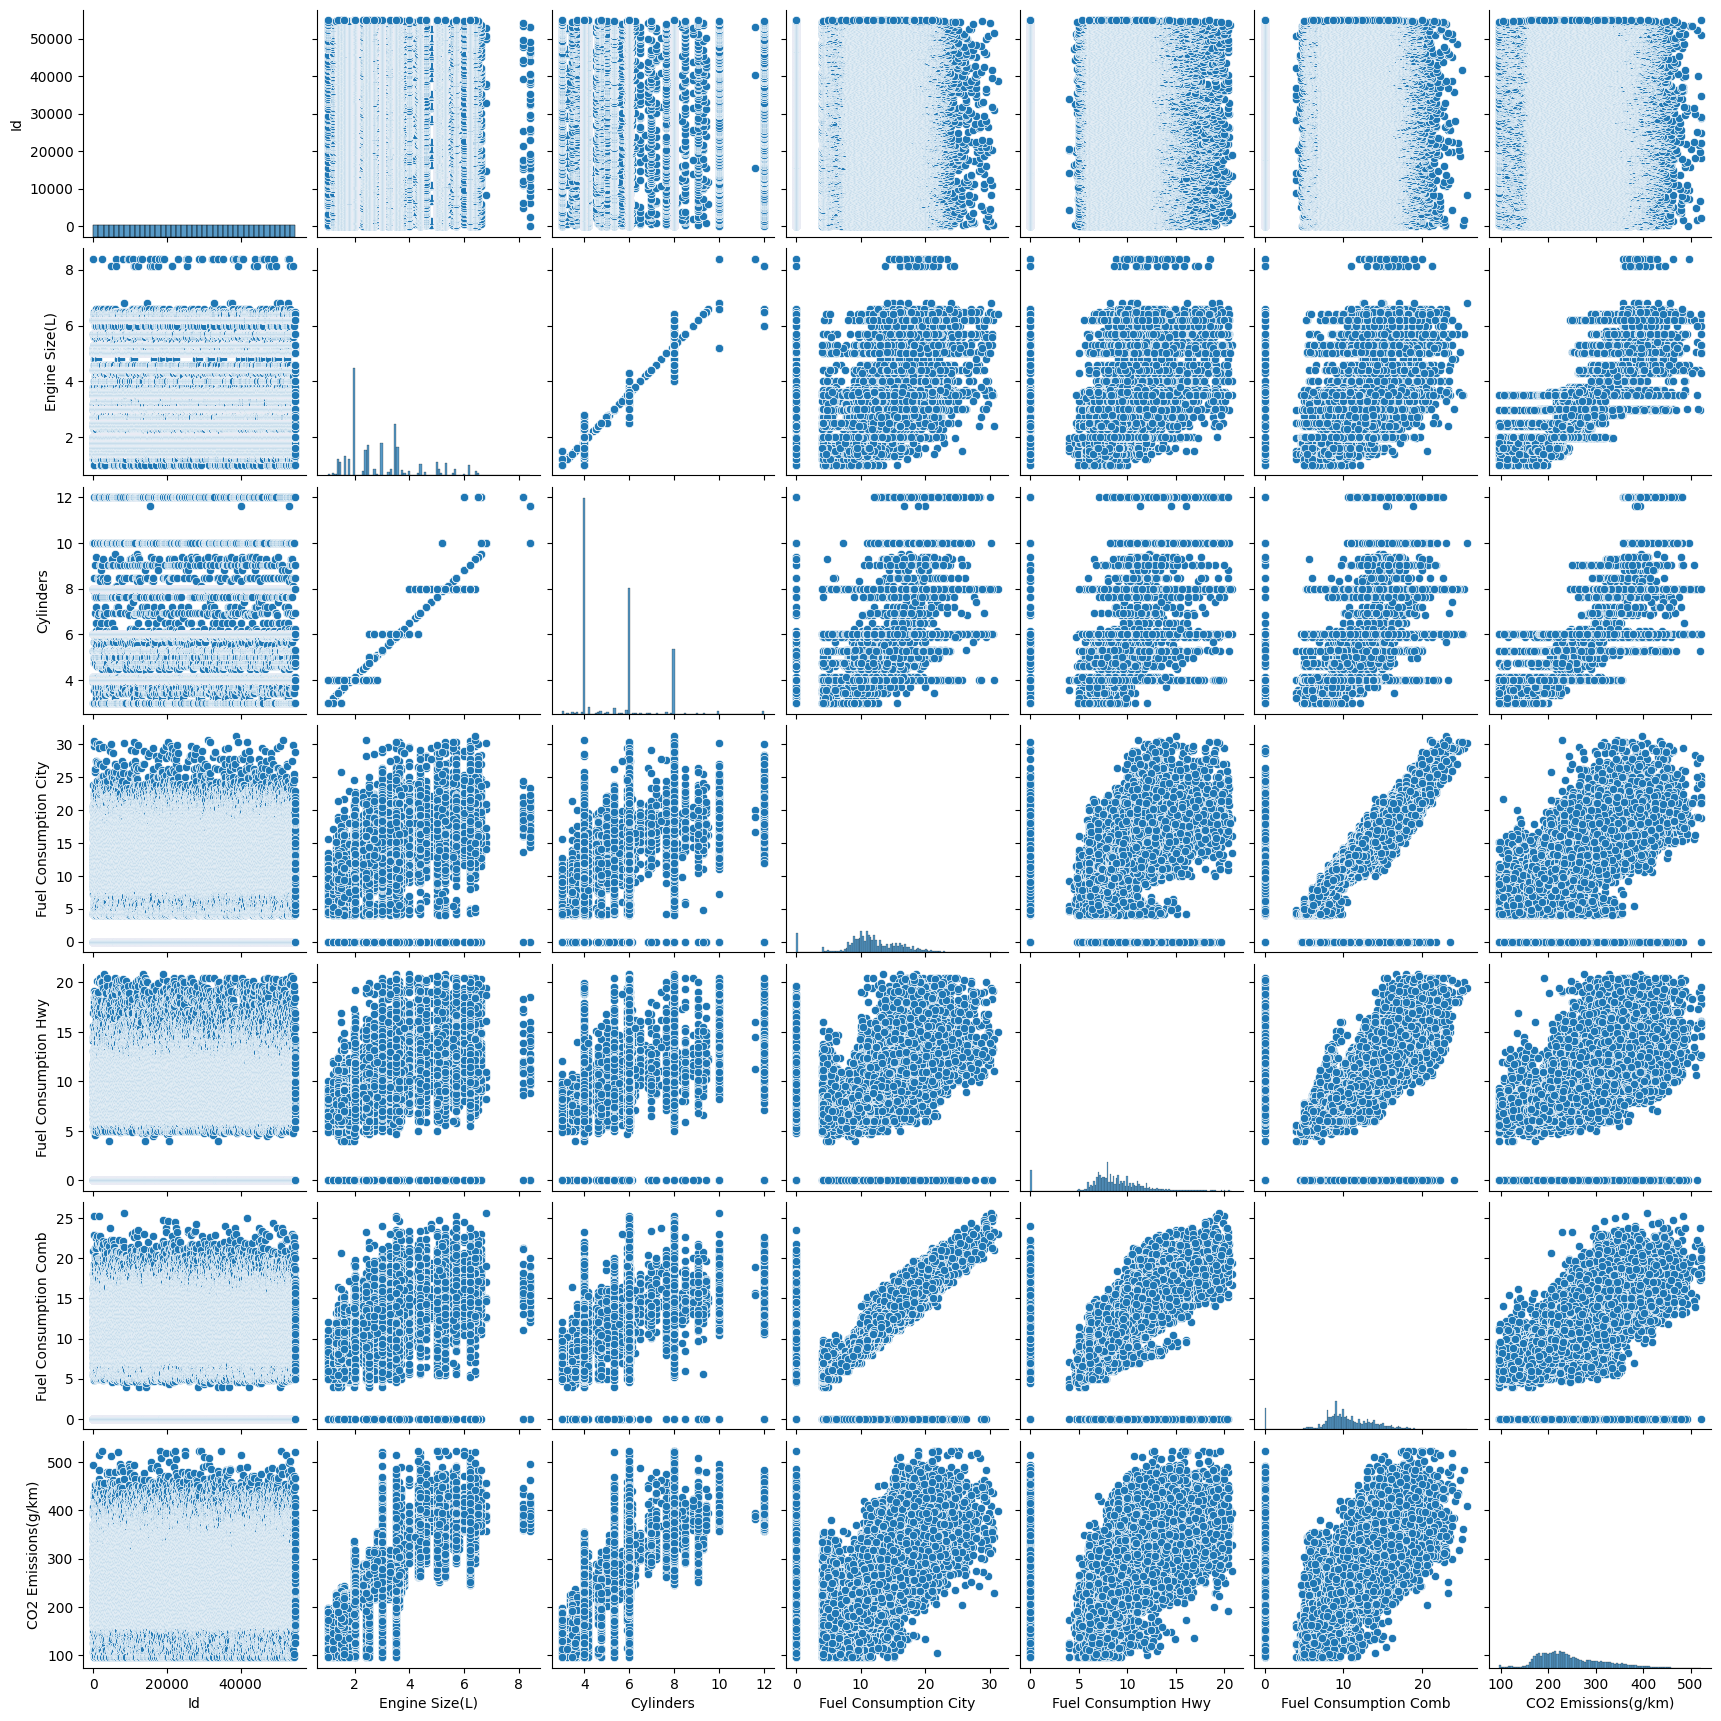

In [ ]:
sns.pairplot(train)

Text(0.5, 1.0, 'Correlation Heatmap')

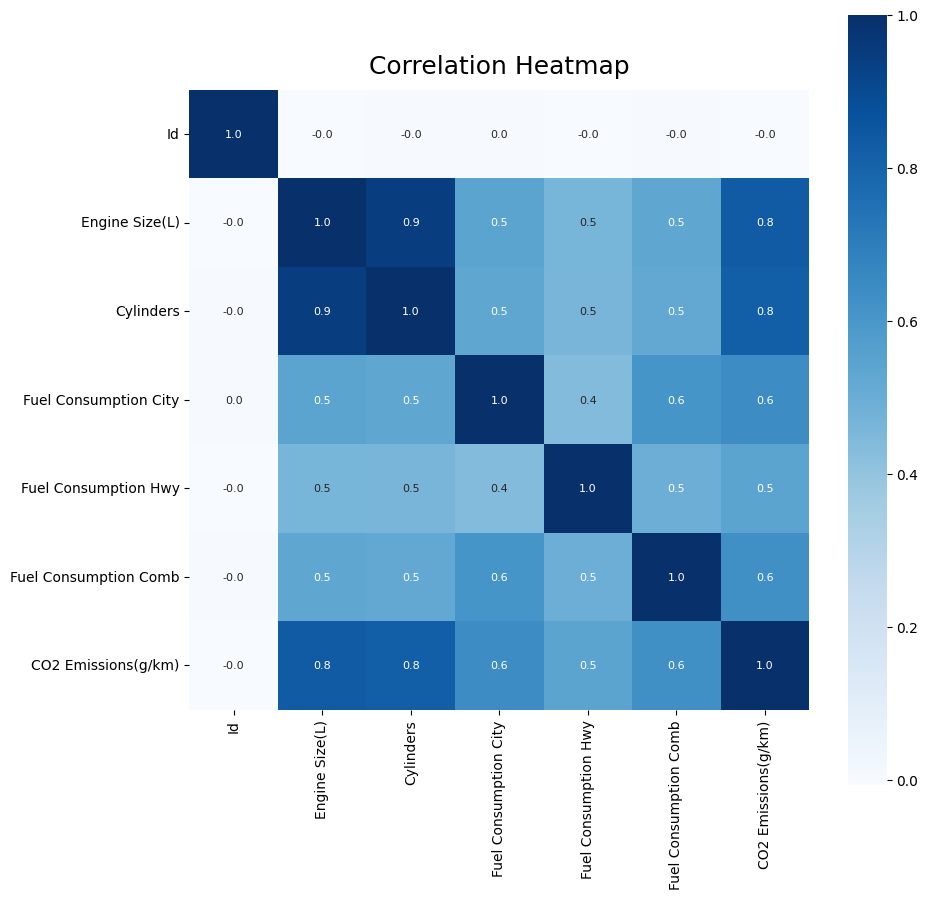

In [ ]:
plt.figure(figsize=(10,10))
heatmap=sns.heatmap(train.corr(), cbar=True, square=True, fmt = '.1f', annot = True, annot_kws={'size':8}, cmap = 'Blues')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

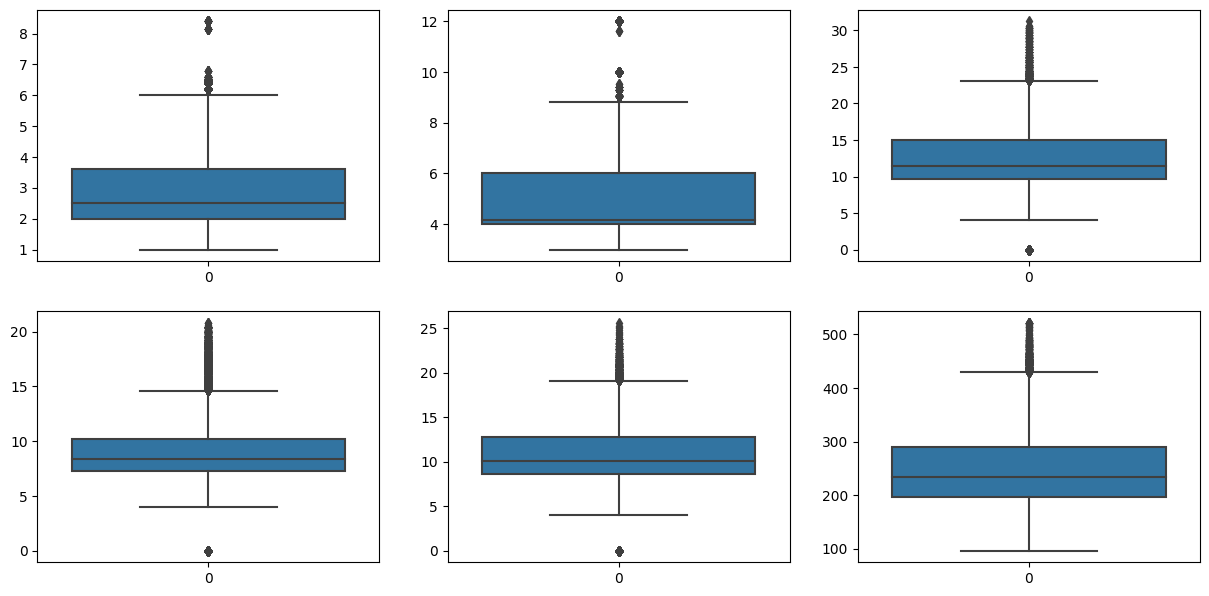

In [ ]:
numeric_columns=['Engine Size(L)', 'Cylinders', 'Fuel Consumption City',
       'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'CO2 Emissions(g/km)']
j=1
fig = plt.figure(figsize = (15,15))
for i in numeric_columns:
    plt.subplot(4,3,j)
    sns.boxplot(train[i])
    j=j+1

<ipython-input-18-1d2c959bd0fb>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train,x=train[col[i]])
<ipython-input-18-1d2c959bd0fb>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train,x=train[col[i]])
<ipython-input-18-1d2c959bd0fb>:8: UserWarning: 

`distplot` is a deprecated function an

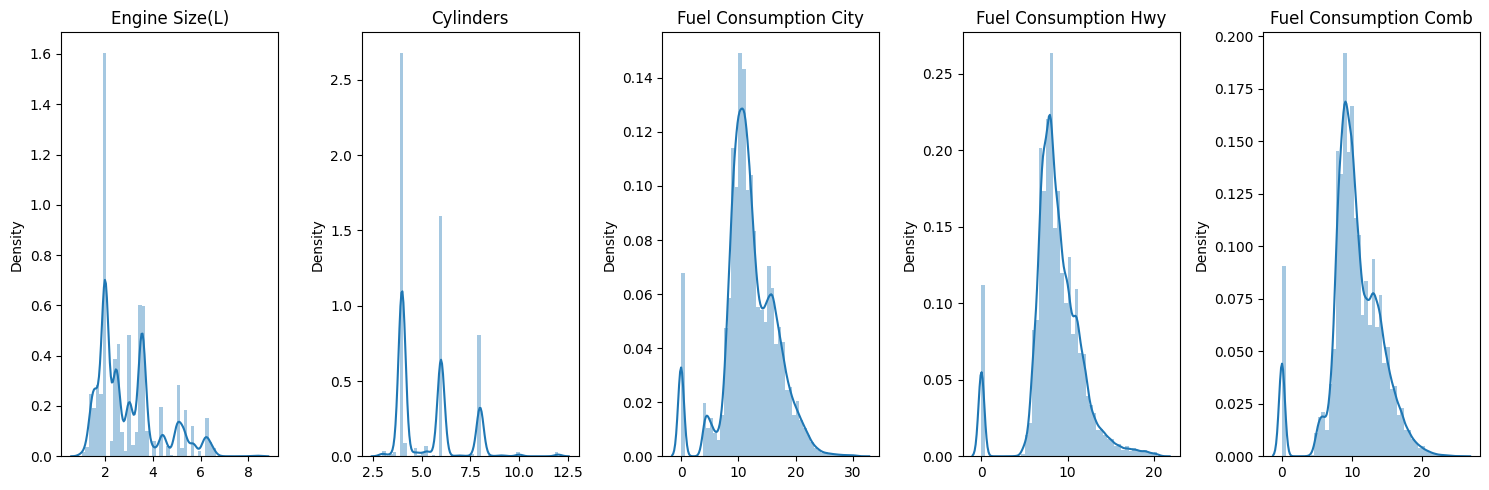

In [ ]:
col=[ 'Engine Size(L)', 'Cylinders',
       'Fuel Consumption City','Fuel Consumption Hwy', 'Fuel Consumption Comb']
fig = plt.figure(figsize=(15,5))

for i in range(len(col)):
    plt.subplot(1,5,i+1)
    plt.title(col[i])
    sns.distplot(train,x=train[col[i]])
plt.tight_layout()
plt.show()

Target Encoding

In [ ]:
from category_encoders import TargetEncoder

target_variable = 'Fuel Consumption City'
categorical_features = ['Make', 'Vehicle Class', 'Transmission', 'Fuel Type']

encoder = TargetEncoder(cols=categorical_features)
df_encoded = encoder.fit_transform(train, train[target_variable])

# data.rename(columns={"CO2 emission": "Encoded_CO2_Emission"}, inplace=True)

ValueError: ignored

### **Building Model**

Multivariate Regression

In [ ]:
train['Fuel Consumption Comb'] = round(0.55 * train['Fuel Consumption Hwy'] + 0.45 * train['Fuel Consumption Hwy'], 2)
train['Fuel Consumption Comb'].sample(20)

14272     8.62
21842     9.00
5926      8.50
19104     7.41
37689    11.49
6786      9.80
5494      9.01
36109     6.31
45716     8.90
30974     7.61
38817    10.31
33908     8.10
11910     5.71
52049     7.00
47584    11.63
14794    13.00
41615     0.00
27619     6.70
36338     8.51
46073     5.80
Name: Fuel Consumption Comb, dtype: float64

In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

model = LinearRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']], y_train)

best_model = grid_search.best_estimator_

best_model.fit(X_train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']], y_train)

y_pred = best_model.predict(X_test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']])

with open('multivariate.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [ ]:
with open('multivariate.pkl', 'rb') as file:
    model = pickle.load(file)

X_test = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]
y_pred = model.predict(X_test)
test['CO2 Emissions(g/km)'] = y_pred

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

ValueError: ignored

In [ ]:
test['CO2 Emissions(g/km)'] = y_pred
test[['Id', 'CO2 Emissions(g/km)']].to_csv('test_apocalypse.csv', index=False)

ValueError: ignored

Lasso Regression

In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pickle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, lasso_params, scoring='neg_mean_squared_error', cv=5)

lasso_grid.fit(X_train, y_train)

best_alpha_lasso = lasso_grid.best_params_['alpha']

lasso_best = Lasso(alpha=best_alpha_lasso)
lasso_best.fit(X_train, y_train)

with open('lasso.pkl', 'wb') as file:
    pickle.dump(best_model, file)

ValueError: ignored

In [ ]:
with open('lasso.pkl', 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 32.39


In [ ]:
test['CO2 Emissions(g/km)'] = y_pred
test[['Id', 'CO2 Emissions(g/km)']].to_csv('test_apocalypse.csv', index=False)

ValueError: ignored

Neural Networks

In [ ]:
X = train[['Engine Size(L)', 'Cylinders','Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import pickle

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(x_train.shape[1],)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")

model.fit(x_train, y_train, epochs=10, batch_size=32)

with open("neural.pkl", "wb") as f:
    pickle.dump(model, f)

Epoch 1/10
1374/1374 [==============================] - 4s 2ms/step - loss: nan
Epoch 2/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan
Epoch 3/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan
Epoch 4/10
1374/1374 [==============================] - 4s 3ms/step - loss: nan
Epoch 5/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan
Epoch 6/10
1374/1374 [==============================] - 4s 3ms/step - loss: nan
Epoch 7/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan
Epoch 8/10
1374/1374 [==============================] - 5s 3ms/step - loss: nan
Epoch 9/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan
Epoch 10/10
1374/1374 [==============================] - 3s 2ms/step - loss: nan


In [ ]:
y_pred = model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred)**0.5

print(f"RMSE: {rmse:.4f}")

344/344 [==============================] - 1s 1ms/step


ValueError: ignored

In [ ]:
test['CO2 Emissions(g/km)'] = y_pred
test[['Id', 'CO2 Emissions(g/km)']].to_csv('test_apocalypse.csv', index=False)

ValueError: ignored

Linear Regression

In [ ]:
train['Fuel Consumption Comb'] = round(0.55 * train['Fuel Consumption Hwy'] + 0.45 * train['Fuel Consumption Hwy'], 2)
train['Fuel Consumption Comb'].sample(20)

27       11.00
37523     8.77
48989     7.52
18204     6.20
26472    10.90
52388     8.33
36374     8.00
51011     7.30
4604      7.12
45104     6.82
37916     8.00
29058     8.40
43908     9.00
13044     6.52
19715    10.00
7022      8.40
245       9.30
6083     11.63
31004    12.90
44053     7.01
Name: Fuel Consumption Comb, dtype: float64

In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

with open('linear.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
test_features = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]

with open('linear.pickle', 'rb') as file:
    model = pickle.load(file)

prediksi = model.predict(test_features)

pembulatan_prediksi = [round(pred, 2) for pred in prediksi]

test["CO2 Emissions(g/km)"] = pembulatan_prediksi

In [ ]:
from sklearn.metrics import mean_squared_error

# Kalkulasi RMSE di berdasarkan data test dan prediksi
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 33.01


In [ ]:
test[['Id', 'CO2 Emissions(g/km)']].to_csv('test_apocalypse.csv', index=False)

XGBoost

In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
from xgboost import XGBRegressor

features = ["Engine Size(L)", "Cylinders", "Fuel Consumption Comb"]
target = "CO2 Emissions(g/km)"

xgb_model = XGBRegressor()
xgb_model.fit(train[features], train[target])

with open('xgboost.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import pickle
from sklearn.metrics import mean_squared_error

with open('xgboost.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

xgb_preds = xgb_model.predict(test[features])

xgb_rmse = mean_squared_error(test[target], xgb_preds, squared=False)
print(f"XGBoost RMSE: {xgb_rmse}")

ValueError: ignored

Lightgbm

In [ ]:
from lightgbm import LGBMRegressor

features = ["Engine Size(L)", "Cylinders", "Fuel Consumption Comb"]
target = "CO2 Emissions(g/km)"

lgbm_model = LGBMRegressor()
lgbm_model.fit(train[features], train[target])

with open('lightgbm.pickle', 'wb') as f:
    pickle.dump(model, f)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 308
[LightGBM] [Info] Number of data points in the train set: 54937, number of used features: 3
[LightGBM] [Info] Start training from score 246.688680


In [ ]:
import pickle
from sklearn.metrics import mean_squared_error

df_test = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb']]

with open('xgboost.pickle', 'rb') as f:
    xgb_model = pickle.load(f)

preds = xgb_model.predict(df_test)

# rmse = mean_squared_error(test[target], preds, squared=False)
# print(f"XGBoost RMSE: {rmse}")

# test = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]

# with open('linear.pickle', 'rb') as file:
#     model = pickle.load(file)

# prediksi = model.predict(test_features)

# pembulatan_prediksi = [round(pred, 2) for pred in prediksi]

# test["CO2 Emissions(g/km)"] = pembulatan_prediksi

ValueError: ignored

Random Forest

In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
import missingno as msno
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

with open('random_forest.pickle', 'wb') as f:
    pickle.dump(model, f)

ValueError: ignored

In [ ]:
test_features = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb']]

with open('linear.pickle', 'rb') as file:
    model = pickle.load(file)

y_pred = rf_model.predict(test_features)

pembulatan_prediksi = [round(pred, 2) for pred in y_pred]

test["CO2 Emissions(g/km)"] = pembulatan_prediksi

Catboost

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
import pickle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', random_seed=42)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=100)

with open('cat.pickle', 'wb') as f:
    pickle.dump(model, f)

0:	learn: 62.5777520	test: 62.0744852	best: 62.0744852 (0)	total: 29.1ms	remaining: 14.5s
100:	learn: 27.6976094	test: 28.2811219	best: 28.2811219 (100)	total: 1.7s	remaining: 6.71s
200:	learn: 27.1393453	test: 27.9336775	best: 27.9336775 (200)	total: 2.61s	remaining: 3.89s
300:	learn: 26.8445594	test: 27.8706334	best: 27.8706334 (300)	total: 3.25s	remaining: 2.15s
400:	learn: 26.6176809	test: 27.8467633	best: 27.8429542 (386)	total: 3.91s	remaining: 965ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 27.84295419
bestIteration = 386

Shrink model to first 387 iterations.


In [ ]:
df_test = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Comb']]

with open('cat.pickle', 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(df_test)

pembulatan_prediksi = [round(pred, 2) for pred in y_pred]

test["CO2 Emissions(g/km)"] = pembulatan_prediksi

In [ ]:
df_train = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Comb']]

with open('cat.pickle', 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(df_train)

pembulatan_prediksi = [round(pred, 2) for pred in y_pred]

train["CO2 Emissions(g/km)"] = pembulatan_prediksi

In [ ]:
test[['Id', 'CO2 Emissions(g/km)']].to_csv('Test_apocalypse.csv', index=False)

In [ ]:
train[['Id', 'CO2 Emissions(g/km)']].to_csv('Train_apocalypse.csv', index=False)

Hyper Parameter Tuning

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle

X = train[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Comb']]
y = train['CO2 Emissions(g/km)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostRegressor()

param_grid = {
    'iterations': [500, 1000],
    'depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'loss_function': ['RMSE'],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = CatBoostRegressor(**best_params)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=100)

with open('cat_tuning.pickle', 'wb') as f:
    pickle.dump(best_model, f)

Output streaming akan dipotong hingga 5000 baris terakhir.
13:	learn: 32.8466626	total: 192ms	remaining: 13.6s
14:	learn: 32.1748481	total: 210ms	remaining: 13.8s
15:	learn: 31.6031415	total: 231ms	remaining: 14.2s
16:	learn: 31.1175099	total: 244ms	remaining: 14.1s
17:	learn: 30.6941650	total: 257ms	remaining: 14s
18:	learn: 30.3158003	total: 270ms	remaining: 14s
19:	learn: 30.0053661	total: 285ms	remaining: 14s
20:	learn: 29.7432360	total: 301ms	remaining: 14s
21:	learn: 29.5283716	total: 314ms	remaining: 14s
22:	learn: 29.3382143	total: 328ms	remaining: 13.9s
23:	learn: 29.1769068	total: 341ms	remaining: 13.9s
24:	learn: 29.0177430	total: 355ms	remaining: 13.8s
25:	learn: 28.8910927	total: 368ms	remaining: 13.8s
26:	learn: 28.7792409	total: 382ms	remaining: 13.8s
27:	learn: 28.6731144	total: 395ms	remaining: 13.7s
28:	learn: 28.5838280	total: 410ms	remaining: 13.7s
29:	learn: 28.5202435	total: 429ms	remaining: 13.9s
30:	learn: 28.4483585	total: 443ms	remaining: 13.8s
31:	learn: 28.4

In [ ]:
df_test = test[['Engine Size(L)', 'Cylinders', 'Fuel Consumption City', 'Fuel Consumption Comb']]

with open('cat_tuning.pickle', 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(df_test)

pembulatan_prediksi = [round(pred, 2) for pred in y_pred]

test["CO2 Emissions(g/km)"] = pembulatan_prediksi

In [ ]:
test[['Id', 'CO2 Emissions(g/km)']].to_csv('test_apocalypse2.csv', index=False)